<a href="https://colab.research.google.com/github/Ash4dev/expert-octo-garbanzo/blob/main/melody_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Ash4dev/expert-octo-garbanzo.git

Cloning into 'expert-octo-garbanzo'...
remote: Enumerating objects: 8527, done.
remote: Counting objects: 100% (8527/8527), done.
remote: Compressing objects: 100% (8333/8333), done.
remote: Total 8527 (delta 197), reused 8513 (delta 193), pack-reused 0
Receiving objects: 100% (8527/8527), 7.64 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [ ]:
# set-ups for the music21 library

# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...
done!
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



In [3]:
import music21
from IPython.display import Image, Audio

In [4]:
def show_score(music):
  display(Image(str(music.write('lily.png'))))

def play_score(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

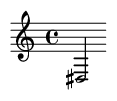

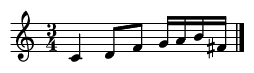

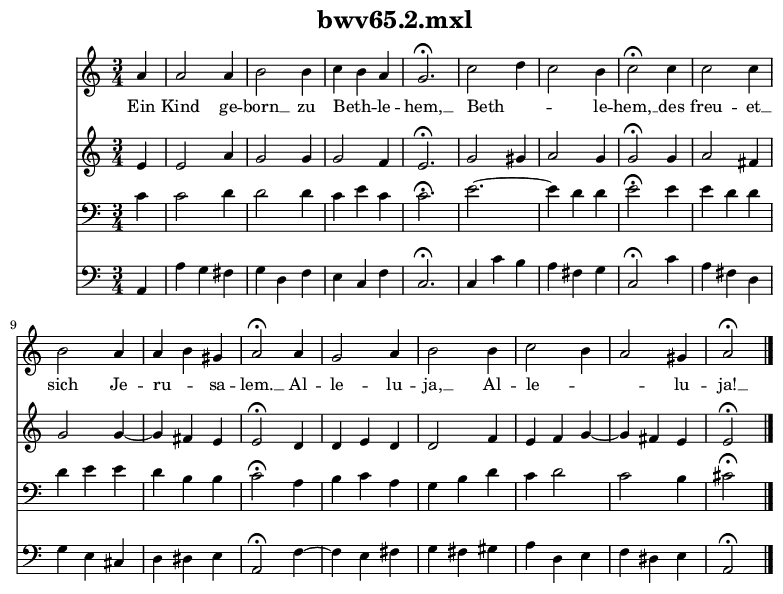

In [ ]:
# proof of work
n = music21.note.Note('D#3')
n.duration.type = 'half'
show_score(n)
play_score(n)

littleMelody = music21.converter.parse('tinynotation: 3/4 c4 d8 f g16 a b f#')
show_score(littleMelody)
play_score(littleMelody)

bach = music21.corpus.parse('bach/bwv65.2.xml')
show_score(bach)
play_score(bach)

### Preprocessing steps

1. loading the data
2. rejecting the data that don't match our requirements
3. the ones that do, we want to transpose them to 2 keys: C_maj and A_min, so that the model can learn faster

In [5]:
import os
import music21

In [ ]:
path_dir = '/content/expert-octo-garbanzo/essen/europa/deutschl'
# understanding os.walk
for dirpath, dirnames, filenames in os.walk(path_dir):
    print(dirpath, dirnames, filenames)

In [ ]:
# PATH_DIR = '/content/expert-octo-garbanzo/essen/europa/deutschl/test'

# # making multiple files load up successively

# def load_kern_files(path_dir):
#   songs = [] # store all the parsed score objects here

#   for dirpath, dirnames, filenames in os.walk(path_dir):
#     for file in filenames:
#       if file[-4:] == '.krn': # we only keep the kern data files
#         score = music21.converter.parse(os.path.join(dirpath, file)) # generates the score of the song
#         songs.append(score)
  
#   return songs

# songs = load_kern_files(PATH_DIR)

In [7]:
# learnings: don't execute the function, where you have defined it, do it in the next cell.

# making multiple files load up successively
def load_kern_files(path_dir):
  
  scores = [] # store all the parsed score objects here

  for dirpath, dirnames, filenames in os.walk(path_dir):
    for file in filenames:
      if file[-4:] == '.krn': # we only keep the kern data files
        try:
          score = music21.converter.parse(os.path.join(dirpath, file)) # generates the score of the song
          scores.append(score)
        except:
          print(f"couldn't generate score for {file} in {dirpath}")

        # scores.append(score)
  
    if len(dirnames) != 0: # helps us to generate scores of the files present in the directory
      for dir in dirnames:
        load_kern_files(os.path.join(dirpath, dir))

  return scores

In [ ]:
PATH_DIR = '/content/expert-octo-garbanzo/essen'
scores = []

scores = load_kern_files(PATH_DIR)
# this function takes a lot of time to run, so a pickle for the same was created

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!unzip /content/drive/MyDrive/scores.zip -d /content/expert-octo-garbanzo

Archive:  /content/drive/MyDrive/scores.zip
  inflating: /content/expert-octo-garbanzo/scores.pickle  


In [ ]:
len(scores)

8473

In [ ]:
# https://stackoverflow.com/a/33245595/19817062

import pickle
your_data = scores

# Store data (serialize)
with open('scores.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
import pickle

In [13]:
with open('/content/expert-octo-garbanzo/scores.pickle', 'rb') as handle:
    scores = pickle.load(handle)

In [14]:
len(scores)

8473

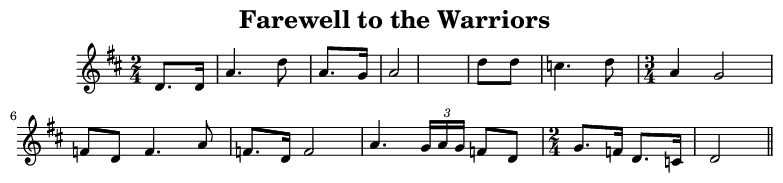

In [15]:
# proper way to test working: unit-testing
show_score(scores[0])
play_score(scores[0])

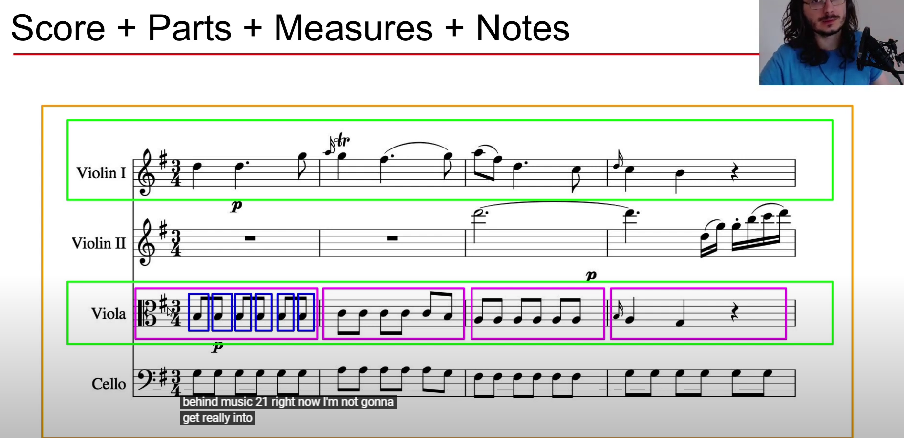

In [35]:
acceptable_durations = [0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]

def has_acceptable_duration(score, acceptable_durations):
  """
  purpose: checking if duration of notes is acceptable
  params: score and list of desired durations
  returns: boolean
  """
  for note in score.flat.notesAndRests: # score is converted to a list of notes and rests
    if note.duration.quarterLength in acceptable_durations: 
      return True
    return False

In [36]:
a = has_acceptable_duration(scores[0], acceptable_durations)
print(a)

True


In [17]:
# transposing score would improve pattern capture of the model rather than learn keys; will pediction be only in amin/cmaj

def transpose_score(score):
    """
    purpose: Transposes song to C maj/A min
    params: piece (m21 stream): Piece to transpose
    returns: transposed_song (m21 stream):
    """

    # get key from the song
    parts = score.getElementsByClass(music21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(music21.stream.Measure)
    key = measures_part0[0][4]
    
    # estimate key using music21 35 min
    key = score.analyze("key")

    # determine the amt of transpose required
    if key.mode == 'major':
      interval = music21.interval.Interval(key.tonic, music21.pitch.Pitch("C"))
    else:
      interval = music21.interval.Interval(key.tonic, music21.pitch.Pitch("A"))

    # transposing the note
    transposed_score = score.transpose(interval)

    return transposed_score

In [59]:
def encode_score(score, time_step = 0.25): # time_step = 0.25 case for 1/16th note
  """
  purpose: create time series data of transposed score
  params: score
  returns: midi based time series
  """

  encoded_score = []

  for event in score.flat.notesAndRests: # while encoding we only care about the notes and rests
    if type(event) == music21.note.Note:
      symbol = event.pitch.midi
    else:
      symbol = 'r'

    steps = event.duration.quarterLength / time_step # quartLength basically refers to a beat

    for step in range(int(steps)):
      if step == 0: # midi code at start of the event
        encoded_score.append(symbol)
      else: # rest of the duration we hold
        encoded_score.append('_')

  encoded_score = " ".join(map(str, encoded_score))

  return encoded_score

In [43]:
def save_file(path, subject):
  '''
  purpose: saving the encoded string
  params: save_location, encoded_song
  returns: None
  '''
  with open(path, "w") as file_ptr:
    file_ptr.write(subject)

In [61]:
# testing if it works or not

enode = encode_score(scores[3])
save_file("/content/cs/enode", enode)

In [63]:
def preprocess(scores):
  """
  purpose: preprocessing krn score
  params: parsed krn file
  returns: 
  """
  for index, score in enumerate(scores): # as a way, to properly index and store our encoded scores to 
    if has_acceptable_duration(score, acceptable_durations):
      transposed_score = transpose_score(score)
      encoded_score = encode_score(transposed_score)
      save_path = os.path.join("/content/prel_dataset", str(index))
      save_file(save_path, encoded_score)
    else:
      print(f"{index} numbered file: not acceptable")

In [64]:
preprocess(scores)

124 numbered file of encod
173 numbered file of encod
238 numbered file of encod
2671 numbered file of encod
3589 numbered file of encod
3979 numbered file of encod
4016 numbered file of encod
4039 numbered file of encod
4041 numbered file of encod
4077 numbered file of encod
4112 numbered file of encod
4134 numbered file of encod
4148 numbered file of encod
4158 numbered file of encod
4175 numbered file of encod
4236 numbered file of encod
4250 numbered file of encod
4263 numbered file of encod
4774 numbered file of encod
4975 numbered file of encod
5654 numbered file of encod
5738 numbered file of encod
5744 numbered file of encod
5761 numbered file of encod
5793 numbered file of encod
5825 numbered file of encod
5886 numbered file of encod
5914 numbered file of encod
5971 numbered file of encod
6275 numbered file of encod
6286 numbered file of encod
6540 numbered file of encod
6660 numbered file of encod
6769 numbered file of encod
6862 numbered file of encod
6900 numbered file of e

In [66]:
import shutil
shutil.copy("/content/prel_dataset/0","/content/drive/MyDrive/prel_dataset")

'/content/drive/MyDrive/prel_dataset'

In [88]:
# it will be easier to learn from the data presented all at once, rather than sequentially 1-2 min

def unify_dataset(data_path, target_path = "/content/unified_dataset", delimiter = '/ ', delimiter_length = 64):
  """
  purpose: unify the sequential datas (for improved pattern capture of the data by the network)
  params: path where the datafiles are located, path where the unified file is to be stored, *
  returns: unified_string/None decide
  """
  new_score_delimiter = delimiter * delimiter_length   # score_end indicator
  unified_string = ""

  for dirpath, dirnames, filenames in os.walk(data_path):
    for index, file in enumerate(filenames):
      with open(os.path.join(data_path, str(file)), 'r') as file_ptr: # the individual files are read
        unified_string += file_ptr.read()
        if index < len(filenames) - 1: # delimiter not to be applied after the last score
          unified_string += " " + new_score_delimiter


  with open(target_path, 'w') as file_ptr: # saving the unified string to a file
    file_ptr.write(unified_string)
  
  return unified_string


In [89]:
dataset = []

In [90]:
dataset = unify_dataset("/content/prel_dataset")
dataset

'60 _ 64 _ 60 _ 64 _ 64 _ 67 _ 64 _ 64 _ 62 _ 64 62 62 _ 62 _ 62 _ 65 _ 62 _ 60 _ 60 _ 60 _ 67 _ 64 _ _ _ 62 _ _ _ 60 _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 67 64 67 _ _ _ 67 69 74 _ _ _ 71 74 71 69 67 69 71 _ 69 67 64 _ 67 _ 67 _ r _ _ _ 69 _ 67 69 71 _ 69 71 67 69 67 64 62 _ _ _ 62 64 67 _ 64 62 59 _ 62 _ 62 _ r _ 62 64 62 64 67 _ 64 62 59 _ 62 _ 62 _ r _ _ _ 62 64 62 64 67 _ 67 _ 62 64 62 64 67 _ 67 _ 62 64 67 _ 64 67 64 62 67 _ _ 69 64 _ 62 _ 60 _ _ _ _ _ _ _ 60 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 60 _ 62 _ 64 _ _ _ 64 _ _ _ 64 _ _ _ 67 _ _ _ 65 _ _ _ 64 _ _ _ 62 _ _ _ 67 _ 65 _ 64 _ _ _ _ _ 62 64 65 _ _ _ _ _ _ _ 64 _ _ _ _ _ _ _ r _ _ _ 67 _ _ _ 72 _ _ _ 71 _ _ _ 69 _ _ _ 67 _ 71 _ 69 _ _ _ 69 _ _ _ 67 _ _ _ 72 _ _ _ 67 _ _ _ _ _ 65 _ 64 _ _ _ 62 _ _ _ 64 _ _ _ _ _ _ _ _ _ _ _ / / / / /

In [103]:
# check if non-desirable characters didn't creep in

valid_symbols = [str(ele) for ele in range(0, 200)]
valid_symbols += [' ', 'r', '_', '/']

def sanity_checked_string(dataset, allowed = valid_symbols):
  """
  purpose: to remove non-desirable characters
  params: dataset string, list of valid symbols
  returns: clean string
  """
  string = ''
  for symbol in dataset.split():
    if symbol not in valid_symbols:
      continue
    else:
      string += symbol + ' '

  return string[:-1]

In [106]:
dataset = sanity_checked_string(dataset, valid_symbols)

In [107]:
with open("/content/unified_dataset", 'w') as file_ptr:
  file_ptr.write(dataset)

In [ ]:
dataset

In [109]:
from google.colab import files
import json

In [110]:
# 'r', '/'. ' ' and '_' are not understandable by the NN, need to convert them into appropriate format.

def create_mapping(dataset, mapping_path = "mapping.json"):
  """
  purpose: create NN understable data(only numerical)
  params: unified_string, location where the map is to be stored
  returns: None
  """
  dictionary = list(set(dataset.split(" "))) # identify all unique events 
  
  map = {}
  for index, event in enumerate(dictionary): # creating the mapping
    map[event] = index

  with open(mapping_path, 'w') as file_ptr:
    json.dump(map, file_ptr)

In [111]:
create_mapping(dataset)

['85', '10', '59', '67', '81', '62', '_', '98', '91', '90', '46', '78', '60', '76', '69', '45', '61', '80', '63', '87', '77', '41', '53', '96', '52', 'r', '86', '103', '95', '54', '71', '82', '49', '79', '/', '93', '51', '64', '43', '47', '66', '83', '73', '57', '58', '48', '56', '74', '84', '89', '65', '75', '100', '40', '70', '68', '55', '50', '72', '88']


In [113]:
files.download("mapping.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>